Preface:
- You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. 
Spending Score is something you assigned to the customers based on your defined parameters like customer behavior and purchasing data.

Problem Statement:
- You own the mall and want to understand the customers, like who can be easily converted - Target Customers, so that the insights can be given to the marketing team in order to plan the strategy accordingly.

For more info:
https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python?select=Mall_Customers.csv

In [1]:
# Imported libraries and modules that we are going to use for the analysis
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import sklearn.linear_model
import seaborn as sns
import warnings
from pandas.plotting import scatter_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Algorithm
from sklearn.cluster import KMeans


In [2]:
# Let's start loading the data
def load_file(File_name):
    """creating a function to load the files"""
    df = pd.read_csv(File_name,thousands=",",delimiter=",",encoding="latin1", na_values="n/a")
    return df

In [3]:
# Loading the data
df = load_file("Mall_Customers.csv")

# DATA  EXPLORATION

In [4]:
# Let's start exploring the data set provided
df.head(10) # Get the data head

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


- Gender attribute is a categorical data. We have to investigate if Gender feature plays an important role
  within the dataset. If it doesn't, we should drop it beacuse k-mean and many other clustering algorithms
  don't work over categorical data - a distance is needed between elements.
  The main challenge with categorical data using k-mean is to transform the categorical attributes into
  numeric ones. A solution could be using k-modes over categorical datasets.

In [5]:
# Let's move on to exploring whether there are missing values
df.info() # Get a quick description of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


There are not null values. We can move on to exploring Gender attribute

In [6]:
# Creating a function to divide the customers by Gender and analyze their percentage over the total number
def table(df,category,value):
    """creating a table that shows the percentage rate over the total number of the chosen category"""
    people = df[df[category]== value] # separating data set 
    return pd.DataFrame({"Groups":category + " " + str(value).title(),
                         "Total":len(people),
                         ("%"): len(people)/len(df[category])}, index = [0])

In [7]:
# Creating a table by Gender attribute 
table_gender = pd.concat([table(df,"Gender","Male"),table(df,"Gender","Female")])
table_gender 

,Groups,Total,%
0,Gender Male,88,0.44
0,Gender Female,112,0.56


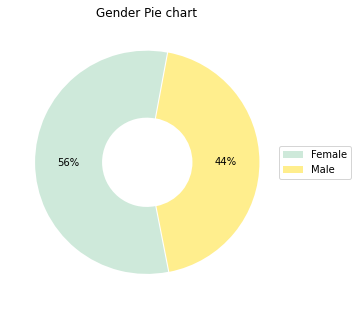

In [8]:
# Plotting the gender table
labels = ["Female", "Male"]
size = df["Gender"].value_counts()
colors = ["#cee9da", "#ffee8d"]
explode = (0, 0.01) # To separate the slices between each other

plt.rcParams["figure.figsize"] = (5, 9)
plt.pie(size, explode = (0, 0.01) , colors = colors, autopct = "%1.0f%%",wedgeprops=dict(width=0.6),
         pctdistance=0.7,startangle=79.5) # I set startangle at 79.5 to align the pie percentages
plt.title("Gender Pie chart")
plt.axis("off")
plt.legend(labels,loc=7,bbox_to_anchor=(0.75, 0.25, 0.5, 0.5))
plt.show()

The majority of customers are female - 56% of the total, where males are only 44% of the total. We can take a look at who spent more between males and females.

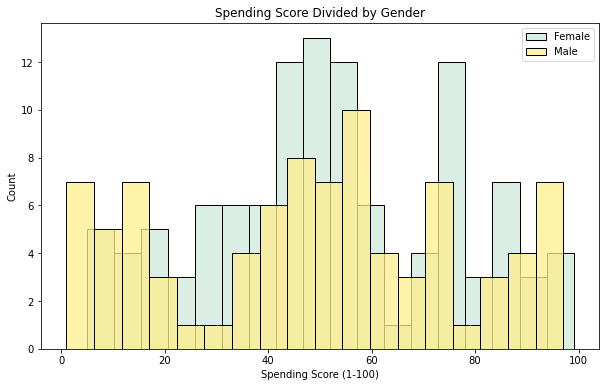

In [9]:
# Plotting Spending_Score by Gender attribute
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

women = df[df["Gender"]=="Female"]
man = df[df["Gender"]=="Male"]

sns.histplot(women["Spending Score (1-100)"], bins=18, label = "Female",
                  color="#cee9da",kde =False)

ax = sns.histplot(man["Spending Score (1-100)"], bins=18, label = "Male", 
                  color="#ffee8d", kde =False)
ax.legend()
_ = ax.set_title("Spending Score Divided by Gender")


- Spending Score grouped by Gender gives us few insights. The Spending Score shows that the mall caters to a variety of customers with different needs. We have valuable customers within male and female groups, and in general, most of the people have a spending score between 35 to 65.
- Now we can drop Gender feature.

Let's move on to exploring the numerical features.

In [10]:
# Let's move on to the non categorical data analysis
df.describe() # Shows a summary of the numerical attributes 

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


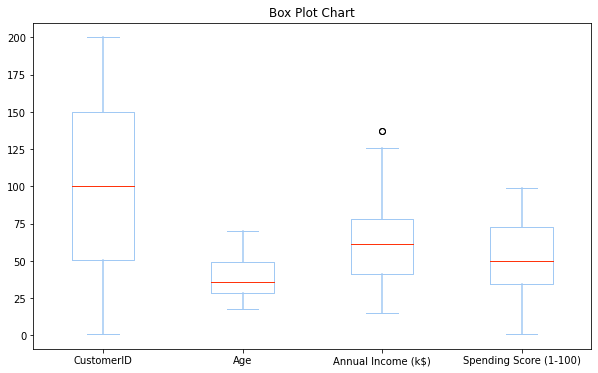

In [11]:
# Visualizing the data above using a box plot where:
# the boxes are the upper and lower quartiles, so the box spans the interquartile range. 
# The medians are the vertical red lines inside the boxes.
# The whiskers are the two lines outside of the boxes that extend to the highest and lowest observations.
color = dict(boxes="#a1c9f4", whiskers="#a1c9f4", medians="#ff340c", caps="#a1c9f4")
box_plot = df.plot.box(figsize=(10,6),color=color, whiskerprops = dict(linestyle="-",
                                                                       linewidth=1.5, color="#a1c9f4"))
plt.title("Box Plot Chart")
plt.show()

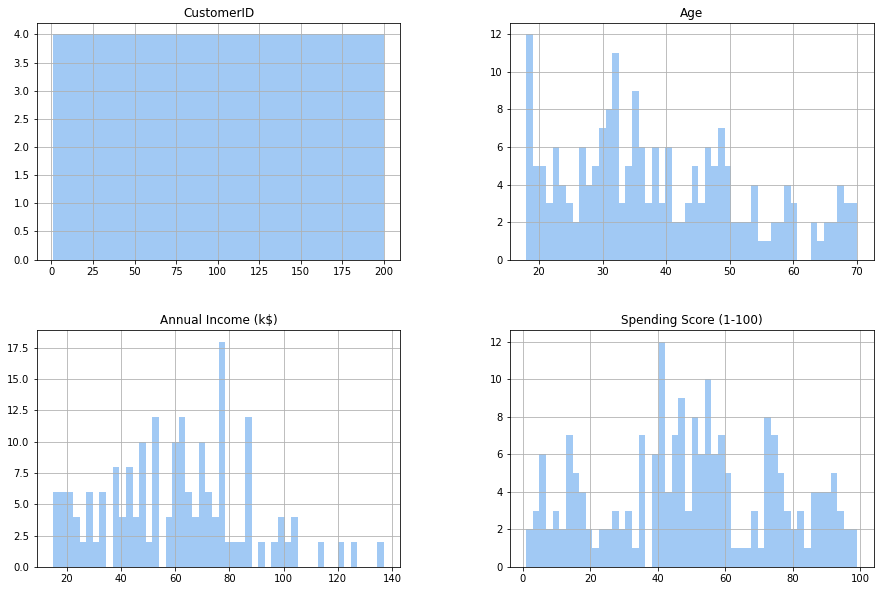

In [12]:
# If you are not familiar with box-plot graphs you can use histograms
df.hist(bins=50, figsize=(15,10), color ="#a1c9f4") # Creating a histogram using data weight
plt.show() # Showing the histogram

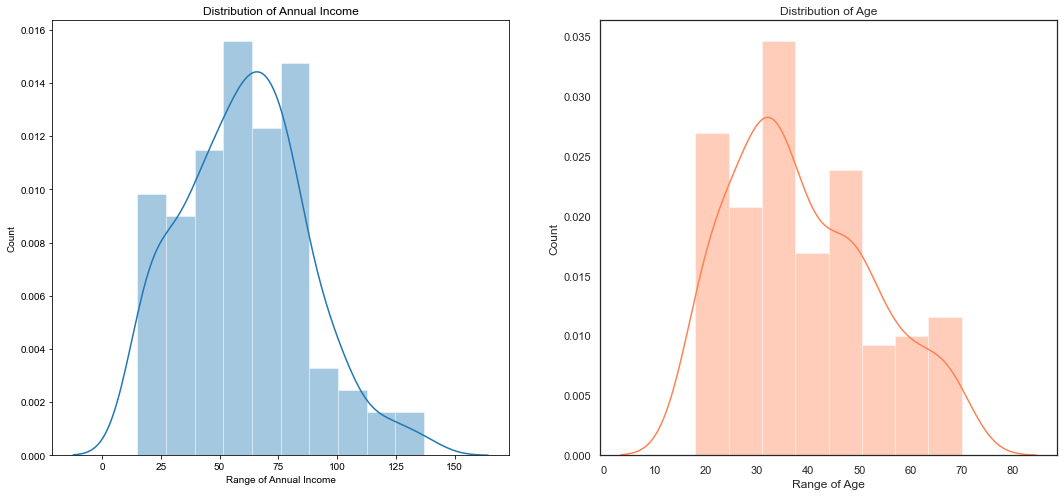

In [13]:
# Let take a closer look to Age and Annual Income
# Plotting Income and Age distribution
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = "white")
sns.distplot(df["Annual Income (k$)"])
plt.title("Distribution of Annual Income")
plt.xlabel("Range of Annual Income")
plt.ylabel("Count")


plt.subplot(1, 2, 2)
sns.set(style = "white")
sns.distplot(df["Age"], color = "#ff8254")
plt.title("Distribution of Age")
plt.xlabel("Range of Age")
plt.ylabel("Count")
plt.show()

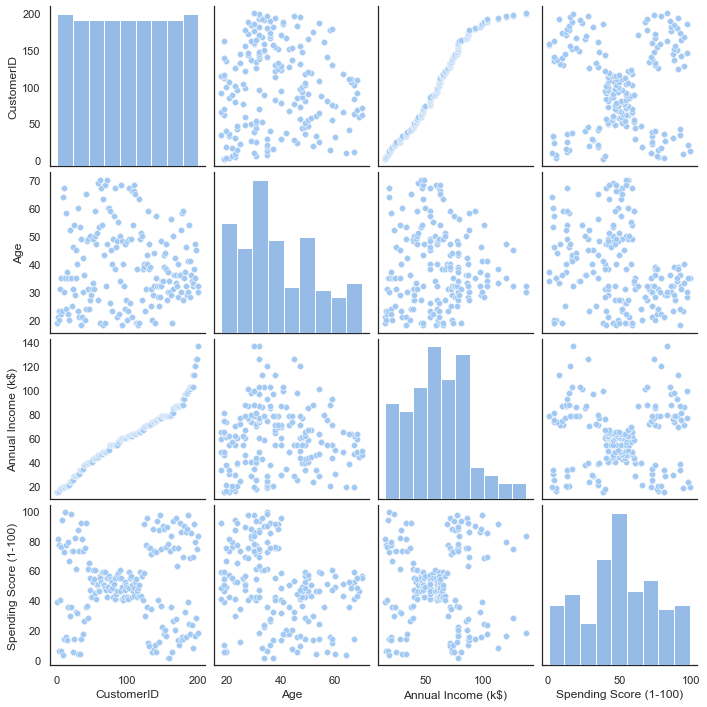

In [14]:
# Let's create a correlation matrix grid where the plot diagonal shows the marginal distribution of 
# the data in each column.
s_matrix = sns.pairplot(df)
s_matrix = s_matrix.map_diag(sns.histplot,color="#a1c9f4")
s_matrix = s_matrix.map_offdiag(sns.scatterplot,color = "#a1c9f4")

From analyzing the graph above - Annual Income and Spending Score - it seems that we could create 5 different clusters.

Is it the right decision? How could we choose the right number of clusters?

We have two options:

    - the elbow method.
    - the silhouette score.

Important:
    The k-mean doesn't work well with elliptical clusters. A solutions is to scale the input features before you 
    run K-Means, or else the clusters may be very stretched, and K-Means will perform poorly. The given data is
    already scaled and we don't need to do so.

# DATA CLEANING

In [15]:
# Dropping Gender attribute
df_kmean = df.drop(["Gender"], axis=1)

# MODEL SELECTION

In [16]:
# Now we can proceed to our k-mean analysis. First, we are going to analyze Spending Score and Income
df_income_spendings = df_kmean.iloc[:, [2, 3]].values # Income [2] and Spending Score [3]

In [17]:
# We have to find the optimal cluster numbers. One solution is the elbow method. Let's create a function to 
# visualize it
def elbow(df,start,end):
    """function that returns to elbow method graph"""
    inertia = []
    for i in range(start, end):
        km = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
        km.fit(df)
        inertia.append(km.inertia_)
    fig, ax = plt.subplots(nrows=1, ncols=1)    
    plt.plot(range(start, end), inertia,color ="#a1c9f4",linewidth =3)
    plt.title("The Elbow Method", fontsize = 20)
    plt.xlabel("N. of Clusters")
    plt.ylabel("Inertia")
    return plt.show()

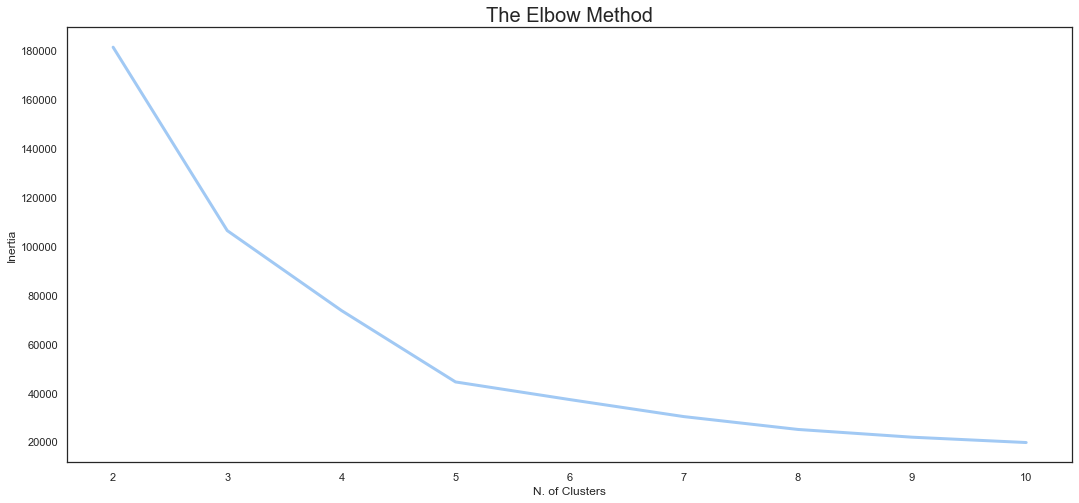

In [18]:
# Plotting elbow method
elbow(df_income_spendings,2,11)

The inertia drops very quickly as we increase the number of clusters up to 5, but then it decreases much more slowly as we keep increasing the number of clusters. This curve has the shape of an arm, and there is an “elbow” where the number of clusters is 5 - so, 5 will be a good choice.

I personally don't like the elbow approach. Sometimes it's hard do understand which is the best number of clusters. I prefer a more precise approach - but also more computationally expensive - the silhouette score.

In [19]:
# Silhouette score
def silhouette(df,range_start,range_end):
    """function that returns to silhouette score method graph"""
    for n_clusters in range(range_start,range_end):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        # The first subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters,
        # to demarcate them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10) 
        cluster_labels = clusterer.fit_predict(df)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        print("For n_clusters =" , n_clusters , "The average silhouette_score is :" , silhouette_avg)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i 
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor="black", alpha=0.4)
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")
            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="#ff340c", linestyle="--",linewidth=2)
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            # Second plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(df[:, 0], df[:, 1], marker=".", s=30, lw=0, alpha=1,c=colors, edgecolor="black")
            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker="o",c="white", alpha=1, s=200, edgecolor="k")
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1,s=50, edgecolor="black")
            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")
            plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),fontsize=14, fontweight="bold")
    return plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3273163942500746
For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5379675585622219
For n_clusters = 7 The average silhouette_score is : 0.5270287298101395
For n_clusters = 8 The average silhouette_score is : 0.4548653400650936
For n_clusters = 9 The average silhouette_score is : 0.4595491760122954
For n_clusters = 10 The average silhouette_score is : 0.4467356774401869


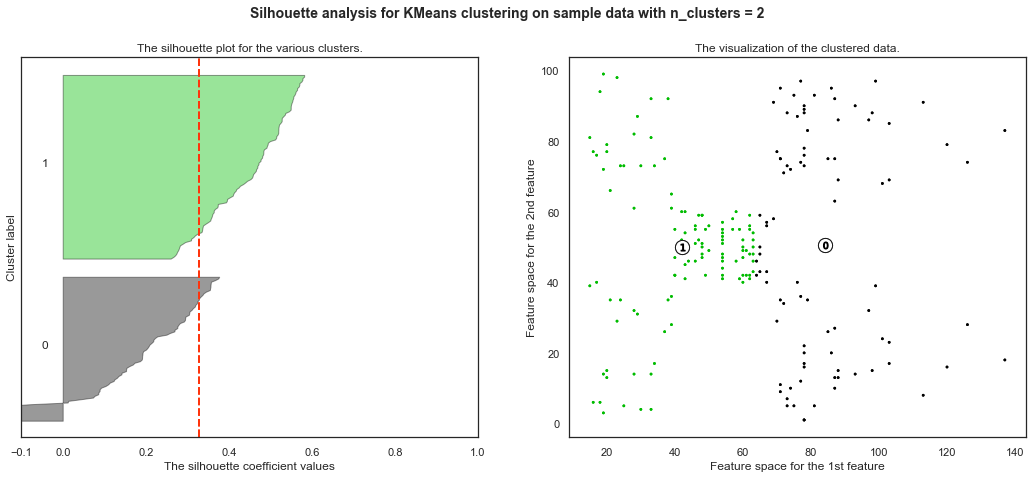

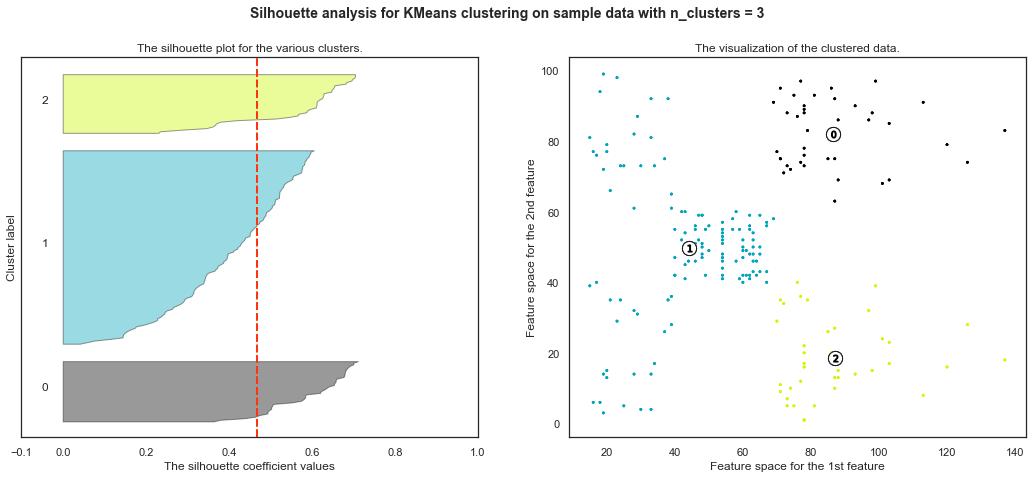

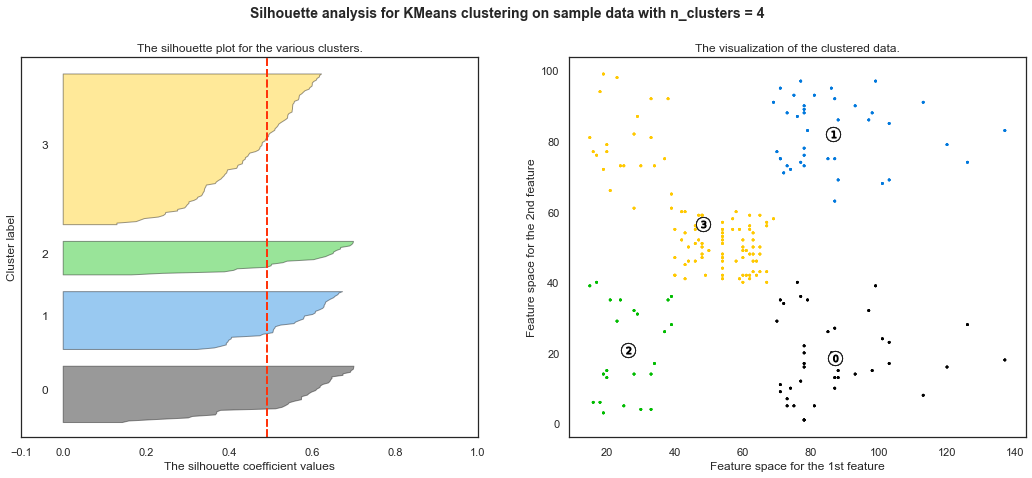

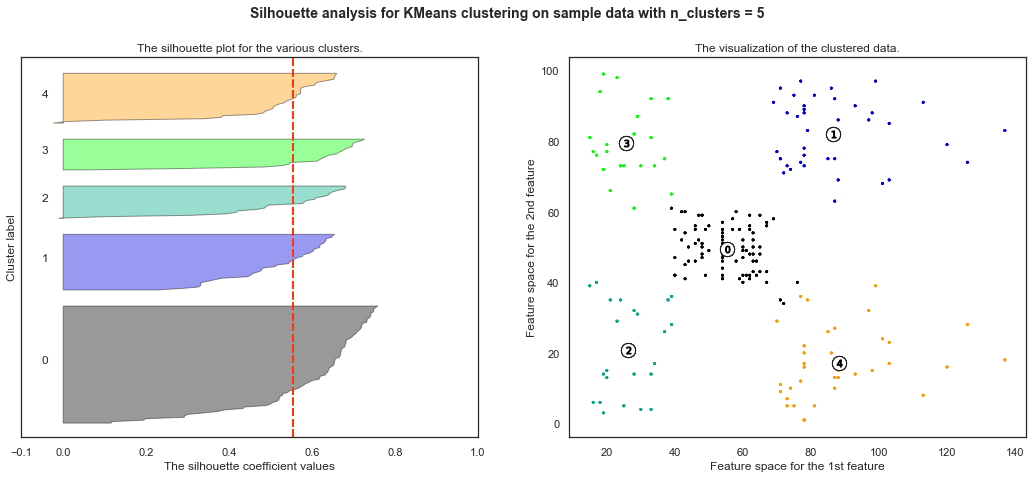

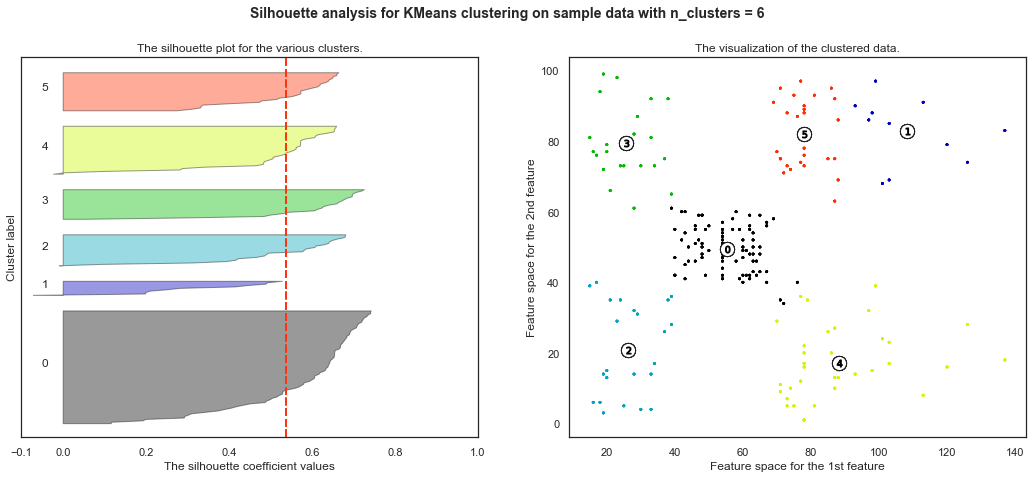

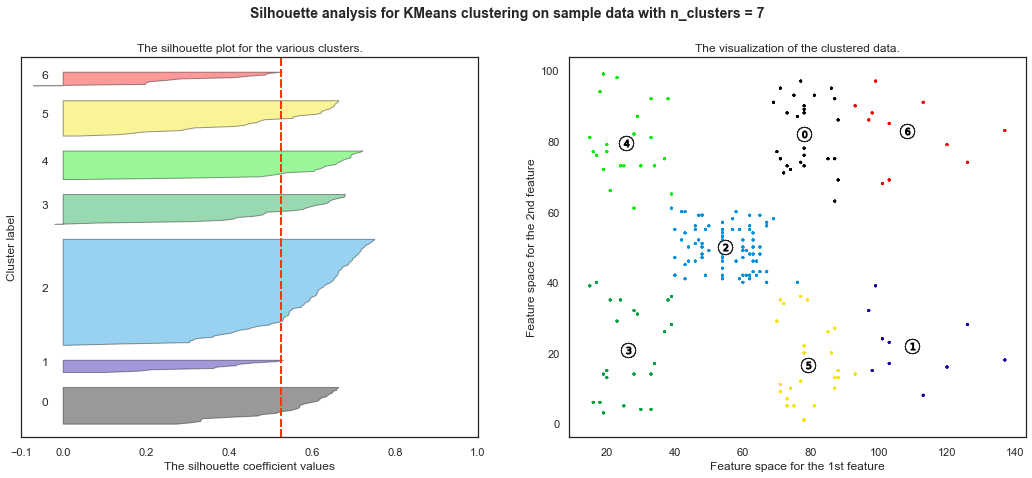

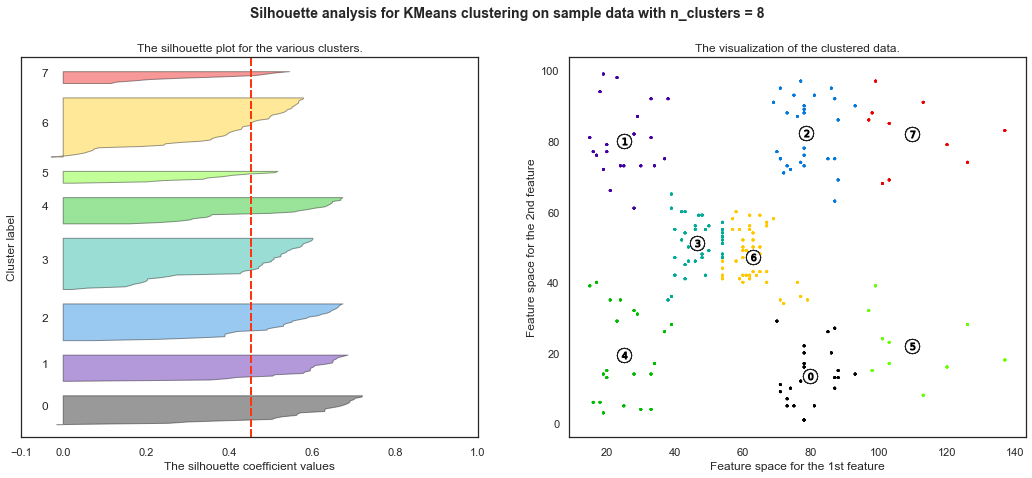

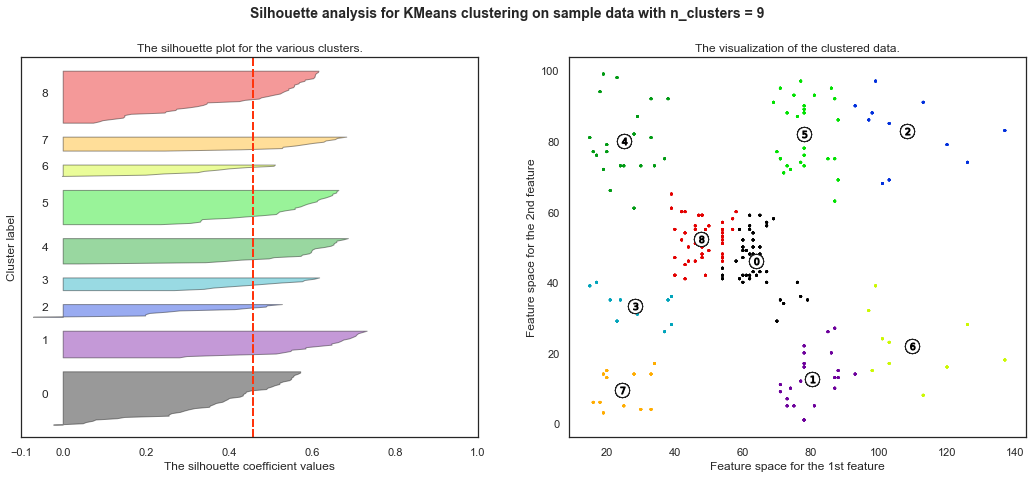

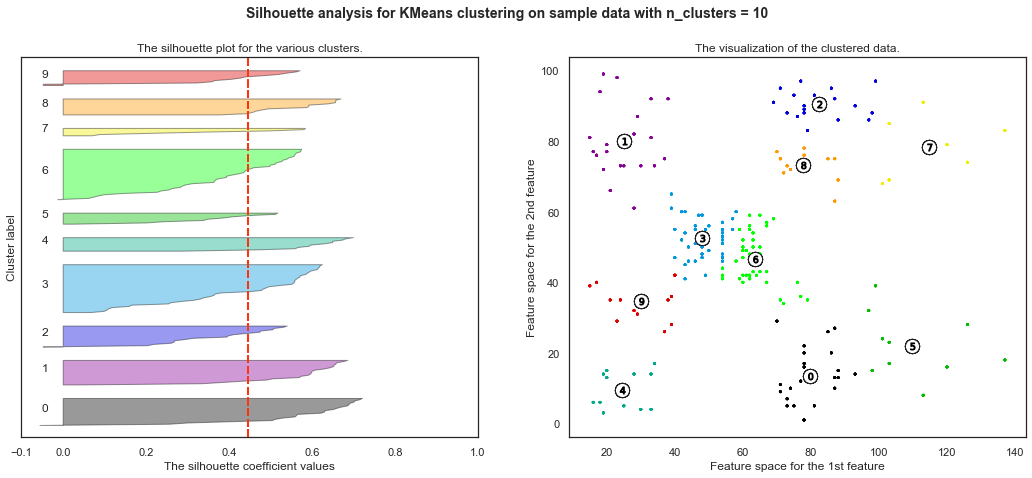

In [20]:
# Plotting silhouette score
silhouette(df_income_spendings,2,11)

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score, the cluster is bad. We can see that when the number of clusters is 5, the clusters and silhouette score are the biggest and all of the clusters have similar sizes. It's a good idea to use 5 as the number of clusters.

In [21]:
# Running KMean alghorithm
km = KMeans(n_clusters = 5, max_iter = 300, n_init = 10)
y_means = km.fit_predict(df_income_spendings)

In [22]:
# Creating a function to visualize the clusters
def km_ploat(df,n_clusters,y_mean,x_label,y_label):
    """functions that returns to the clusters graph"""
    for x in range(0,n_clusters):
        colors = cm.nipy_spectral(float(x) / n_clusters)
        plt.scatter(df[y_means == x, 0], df[y_means == x, 1], s = 100, color = colors,alpha=0.5, label = "Cluster "
                    + str(x))
        centers = km.cluster_centers_
        # Draw white circles at cluster centers
        plt.scatter(centers[:, 0], centers[:, 1], marker="o",c="white", alpha=1, s=300, edgecolor="black")
        for i, c in enumerate(centers):
                plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="black")
        plt.title("K Means Clustering", fontsize = 15)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(loc=7, prop={"size": 20})
        plt.grid()
    return plt.show()

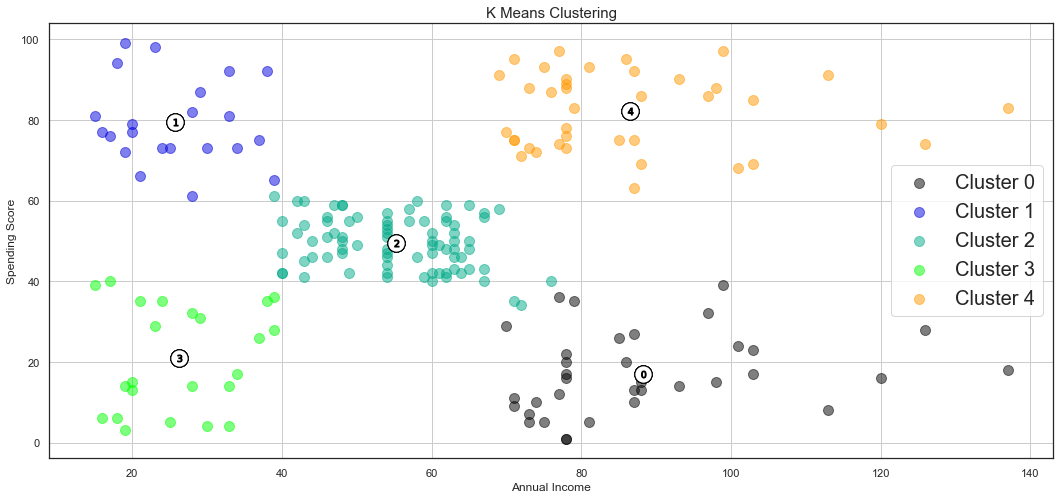

In [23]:
# Visualizing the clusters - Graph n.1
km_ploat(df_income_spendings,5,y_means,"Annual Income","Spending Score")

K-mean aggregated the mall customers into 5 different categories. We can see that Cluster 0, even though their income is high, their spending score is low. 

Why? Is it a product problem? 

We should investigate further, taking into account the customer's age.

In [24]:
# Let's proceed to Age and Spending Score analysis.
df_age_spendings = df_kmean.iloc[:, [1, 3]].values # Age [1] and Spending Score [3]

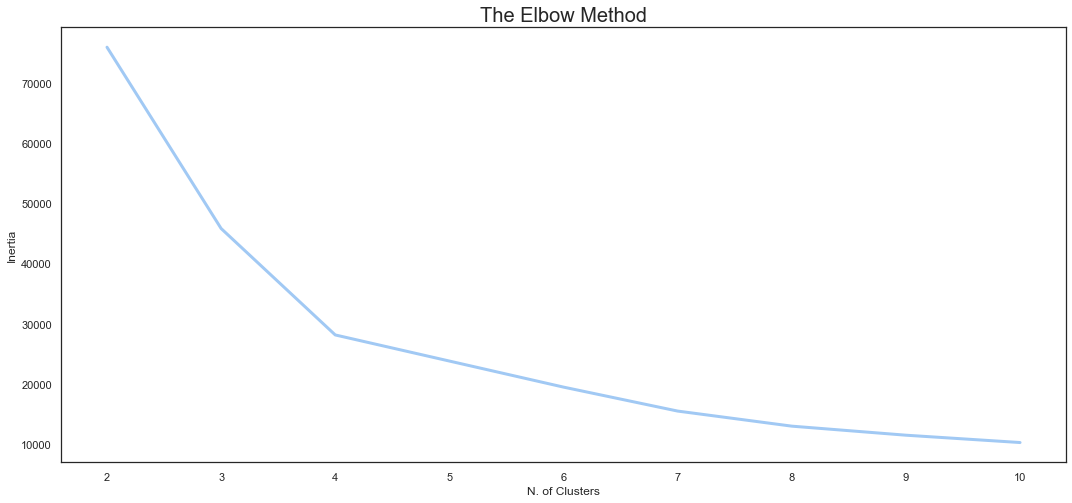

In [25]:
# Plotting the elbow method
elbow(df_age_spendings,2,11)

The inertia drops very quickly as we increase the number of clusters up to 4 - so, 4 will be a good choice.
Let's check the silhouette score to be sure about our findings.

For n_clusters = 2 The average silhouette_score is : 0.4692341232501655
For n_clusters = 3 The average silhouette_score is : 0.45300127016521263
For n_clusters = 4 The average silhouette_score is : 0.49973941540141753
For n_clusters = 5 The average silhouette_score is : 0.4637153212245473
For n_clusters = 6 The average silhouette_score is : 0.4405479018621985
For n_clusters = 7 The average silhouette_score is : 0.4212938931368575
For n_clusters = 8 The average silhouette_score is : 0.4331607448298594
For n_clusters = 9 The average silhouette_score is : 0.4193675464250694
For n_clusters = 10 The average silhouette_score is : 0.4167445093031178


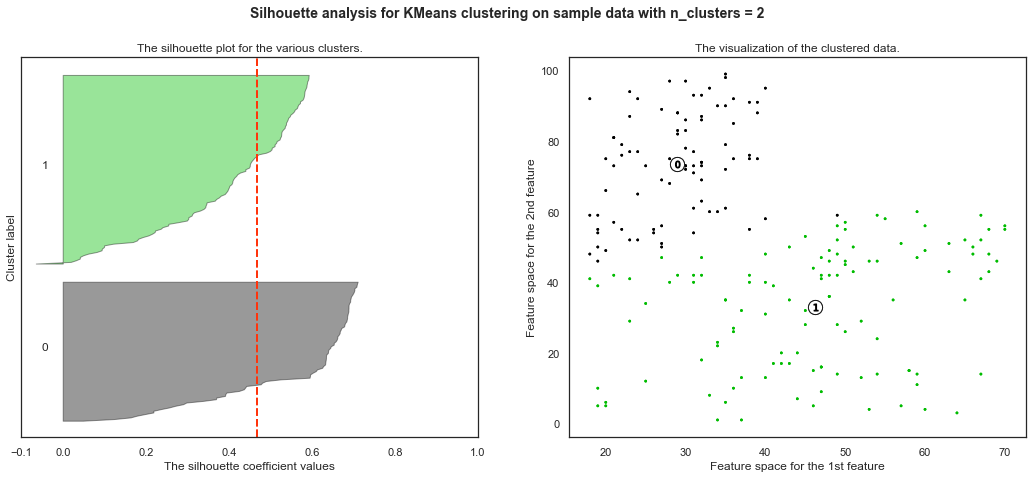

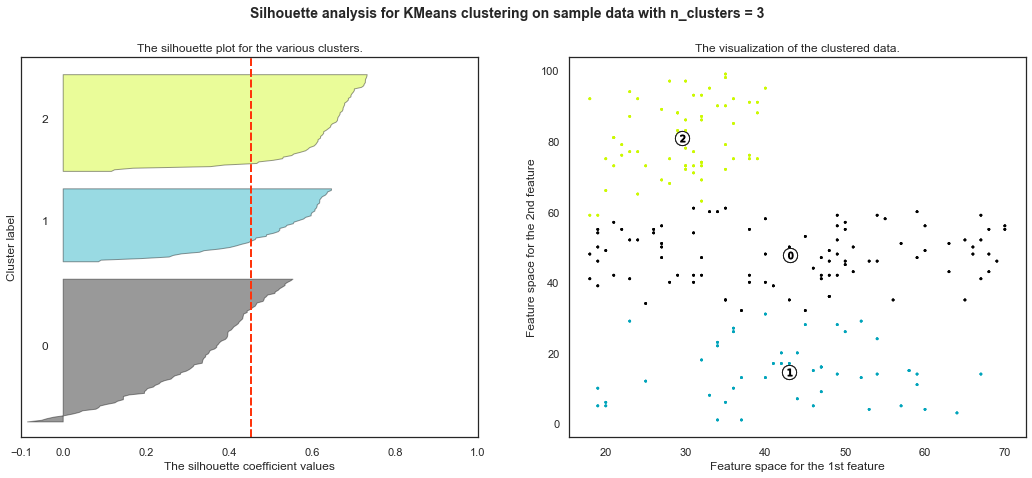

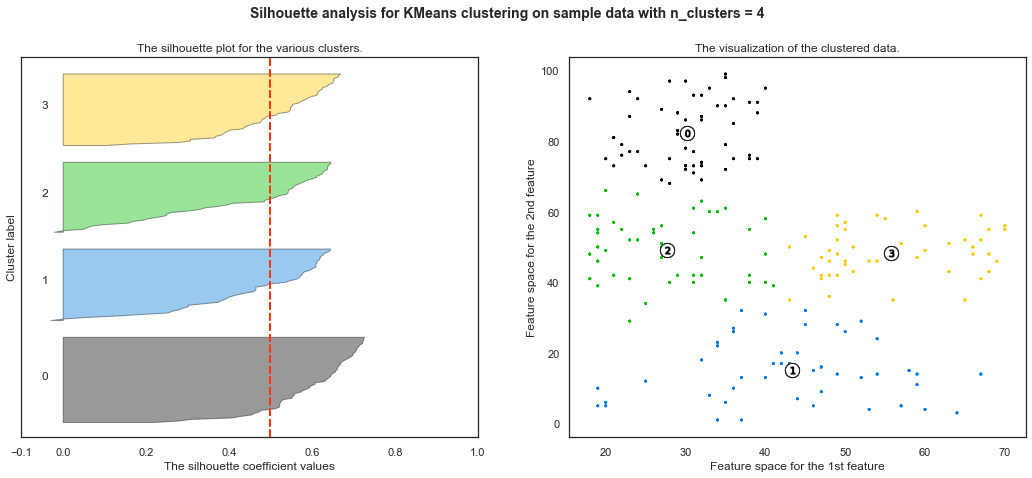

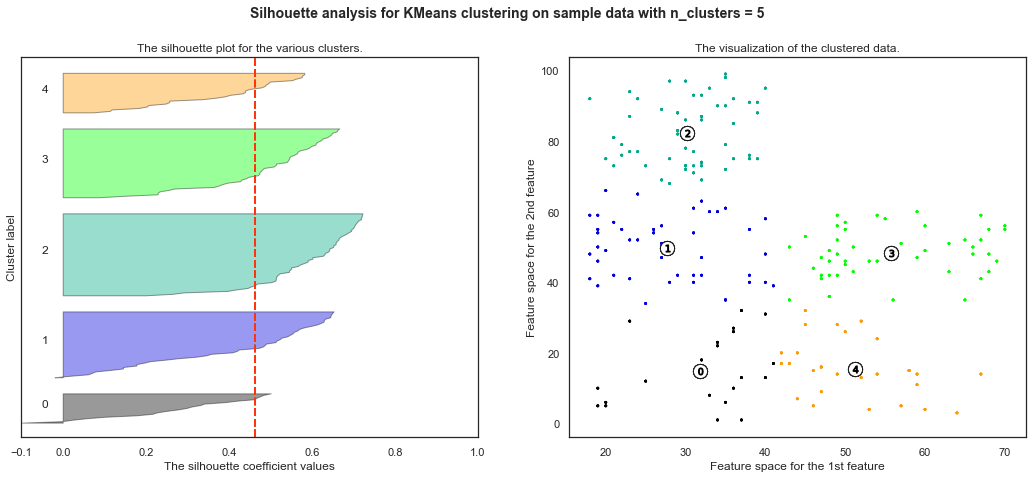

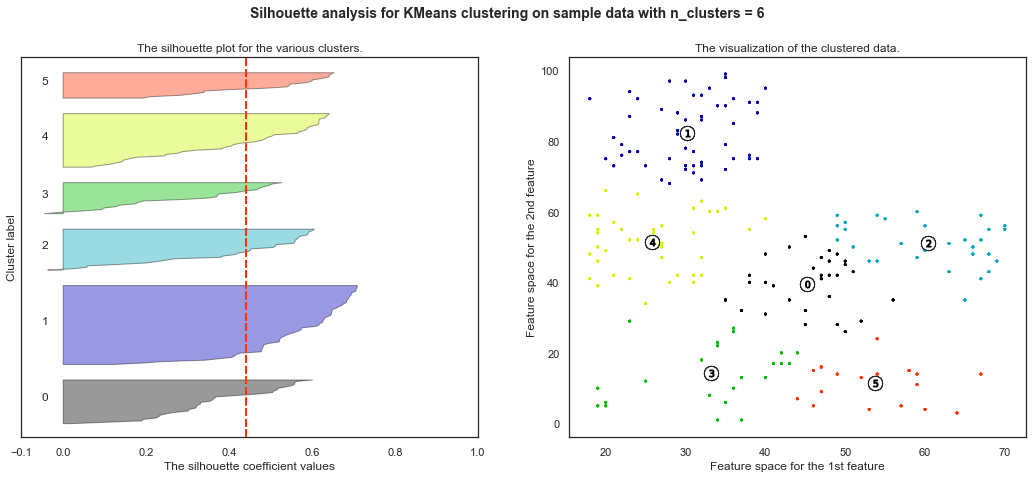

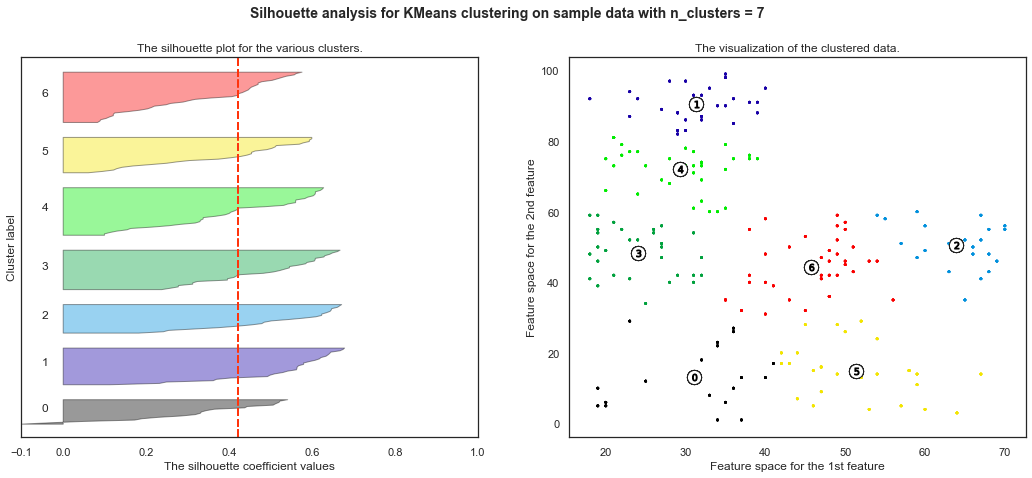

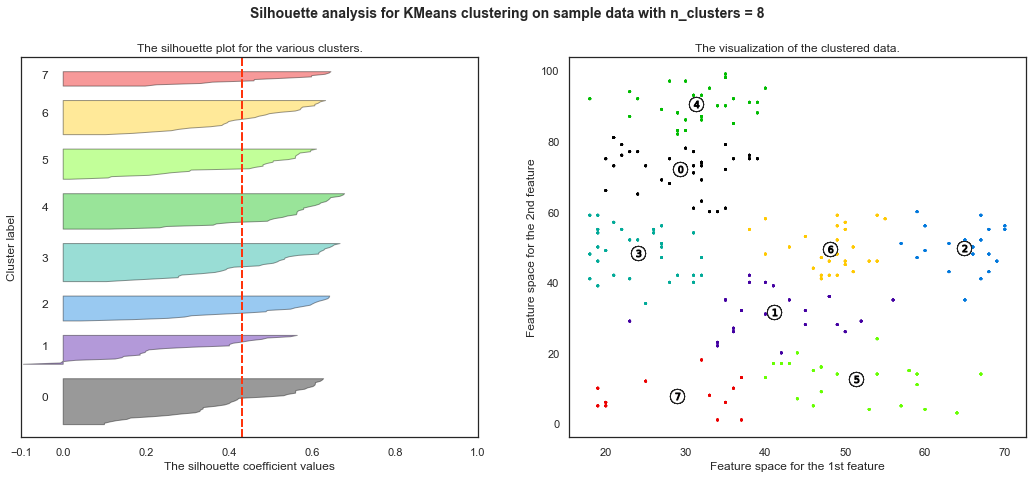

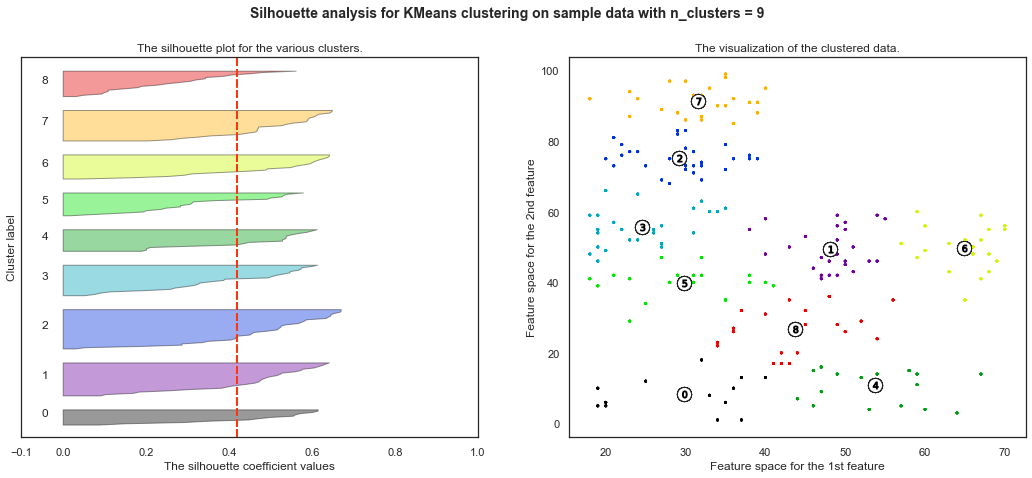

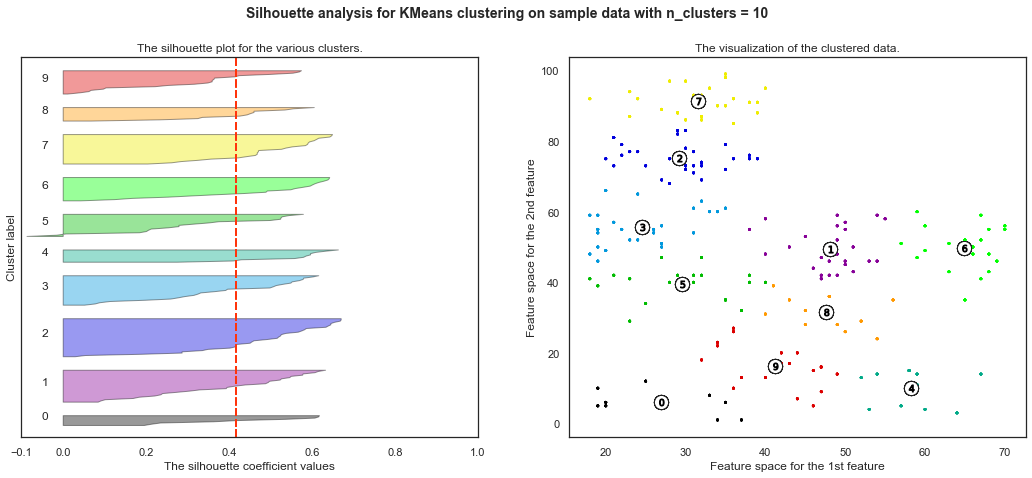

In [26]:
# Plotting the silhouette score
silhouette(df_age_spendings,2,11)

It's a good idea to use 4 as number of clusters - the clusters and silhouette score are the biggest and all the clusters have similar sizes.

In [27]:
# Running KMean alghorithm
km = KMeans(n_clusters = 4, max_iter = 300, n_init = 10)
y_means = km.fit_predict(df_age_spendings)

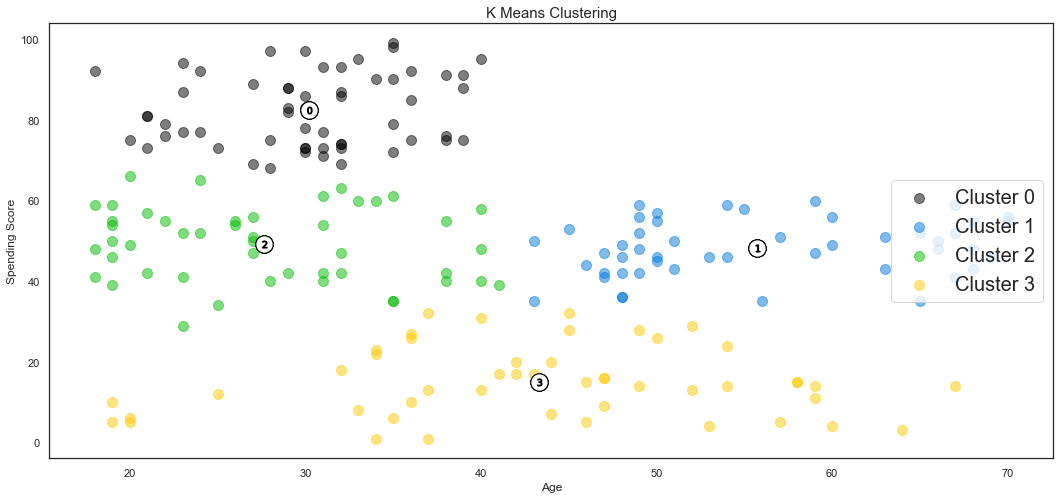

In [28]:
# Visualizing the clusters - Graph n.2
km_ploat(df_age_spendings,4,y_means,"Age","Spending Score")

Comparing the two graphs - Spending Score and Income vs Spending Score and Age - young customers are willing to spend more, even if they have low income they have a higher spending score. In more detail, from graph n.1, we know that there are two different clusters with a high Spending Score compared to their Income - cluster number 2 and cluster number 0. Instead, from the graph above - graph n.2 - we have only one cluster that has a high Spending Score - customers between 20 to 40 years old. Combining the evidence we were able to state that young customers - between 20 to 40 years old - are willing to spend more, even if their income is not that high. 

That's great, but what about older customers? Why do older clients not spend as much as younger ones?

Before answering this question, we should create data labels for our clusters in order to bundles our findings:
- Cluster 0 -> Golden Customer - young customers, regardless of their income, their spending score is high.
- Cluster 1 -> Leaking Bucket - older customers that, even with a high income, don't have a high spending score.
- Cluster 2 -> High Potential - young customers, with medium income and medium spending score.
- Cluster 3 -> Nascent - young and old customers that are likely new to the mall.

Why do Leaking Bucket customers not spend as much as High Potential or Golden ones?

An answer could be that there are not enough products for them, and the products sold at the mall are mainly targeted for younger generations.

A solution, for ex., could be to improve their product lines by selling new products and brands for them.

This is only one strategy. We can now make different marketing campaigns to optimize clients spending scores, or for ex., give discounts to our Golden Customers in order to keep them buying at the mall.

The last thing that we can do is to propagate our labels/findings into our dataset. 

In [29]:
# Creating a new feature called Customer Segments and filling it with our cluster labels 
df["Customer Segments"] = km.labels_
df.loc[df["Customer Segments"] == 0,"Customer Segments"] = "Golden Customer"
df.loc[df["Customer Segments"] == 1,"Customer Segments"] = "Leaking Bucket"
df.loc[df["Customer Segments"] == 2,"Customer Segments"] = "High Potential"
df.loc[df["Customer Segments"] == 3,"Customer Segments"] = "Nascent"

In [30]:
# Our customer segments distribution
df["Customer Segments"].value_counts()

Golden Customer    57
Nascent            48
Leaking Bucket     48
High Potential     47
Name: Customer Segments, dtype: int64

In [31]:
# Exploring the new data set
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Customer Segments
0,1,Male,19,15,39,High Potential
1,2,Male,21,15,81,Golden Customer
2,3,Female,20,16,6,Nascent
3,4,Female,23,16,77,Golden Customer
4,5,Female,31,17,40,High Potential
5,6,Female,22,17,76,Golden Customer
6,7,Female,35,18,6,Nascent
7,8,Female,23,18,94,Golden Customer
8,9,Male,64,19,3,Nascent
9,10,Female,30,19,72,Golden Customer


We used k-means to produce an initial partition. Now, we could continue as we would if the data would have been user-labeled.

For ex., run the k-means, then train an SVM algorithm on the resulting clusters. Afterwards, use SVM for classification on future data.